<a href="https://colab.research.google.com/github/SANKARI-RV146/SHELL-WEEK-1/blob/main/EV_Smart_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet xgboost lightgbm scikit-learn pandas numpy shap matplotlib gradio joblib optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.9 MB/s eta 0:00:00


In [2]:
import os, pandas as pd, numpy as np, joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBRegressor
import lightgbm as lgb
import shap, matplotlib.pyplot as plt

In [5]:
import os
UPLOAD_PATH = r"C:\Users\RAGHAV\Downloads\archive\electric_vehicles_spec_2025.csv.csv"
if not os.path.exists(UPLOAD_PATH):
    # interactive upload (uncomment if needed)
        from google.colab import files
        uploaded = files.upload()



Saving electric_vehicles_spec_2025.csv.csv to electric_vehicles_spec_2025.csv.csv


In [6]:
import pandas as pd
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")
df.head()

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5


In [7]:

df.drop_duplicates(inplace=True)
df.dropna(axis=1, thresh=len(df)*0.7, inplace=True)  # remove columns with >30% missing
df.fillna(df.median(numeric_only=True), inplace=True)
print("✅ Cleaning Done!")

✅ Cleaning Done!


In [8]:
# 4️⃣ ENCODE CATEGORICAL COLUMNS
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_enc.fit_transform(df[col].astype(str))

    print("✅ Encoding Done!")
    df.head()

✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!
✅ Encoding Done!


In [9]:
# 5️⃣ CHOOSE TARGET VARIABLE
target_candidates = [c for c in df.columns if 'range' in c.lower()]
print("🎯 Possible Target Columns:", target_candidates)

# Choose the first matching one
target = target_candidates[0]
X = df.drop(columns=[target])
y = df[target]

🎯 Possible Target Columns: ['range_km']


In [10]:
# 6️⃣ TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Split and Scaled Successfully!")

✅ Data Split and Scaled Successfully!


In [11]:
# 7️⃣ MODEL TRAINING
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators': [100, 200],'max_depth': [10, 20, None],'min_samples_split': [2, 5]}
grid = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_rf = grid.best_estimator_
print("🏆 Best Parameters:", grid.best_params_)

🏆 Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
# 8️⃣ EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_rf.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.2f}")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R² Score: {r2:.3f}")

📊 MAE: 13.19
📉 MSE: 343.18
📈 R² Score: 0.968


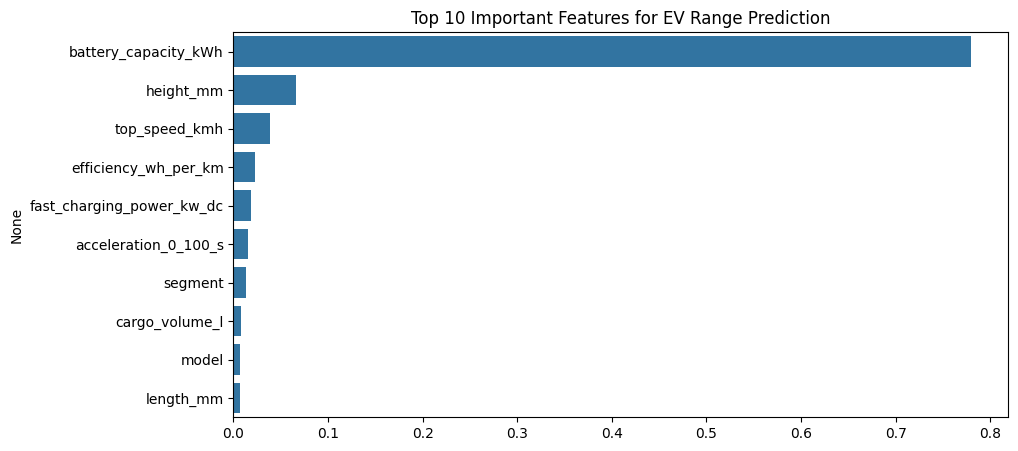

In [13]:
# 9️⃣ FEATURE IMPORTANCE VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features for EV Range Prediction")
plt.show()

In [14]:
# 🔟 SAVE MODEL
import joblib

joblib.dump(best_rf, "ev_range_predictor.pkl")
joblib.dump(scaler, "ev_scaler.pkl")

print("💾 Model Saved Successfully as:")
print(" - ev_range_predictor.pkl")
print(" - ev_scaler.pkl")

💾 Model Saved Successfully as:
 - ev_range_predictor.pkl
 - ev_scaler.pkl


In [15]:
accuracy = r2 * 100
print(f"✅ Model Accuracy: {accuracy:.2f}%")

✅ Model Accuracy: 96.76%


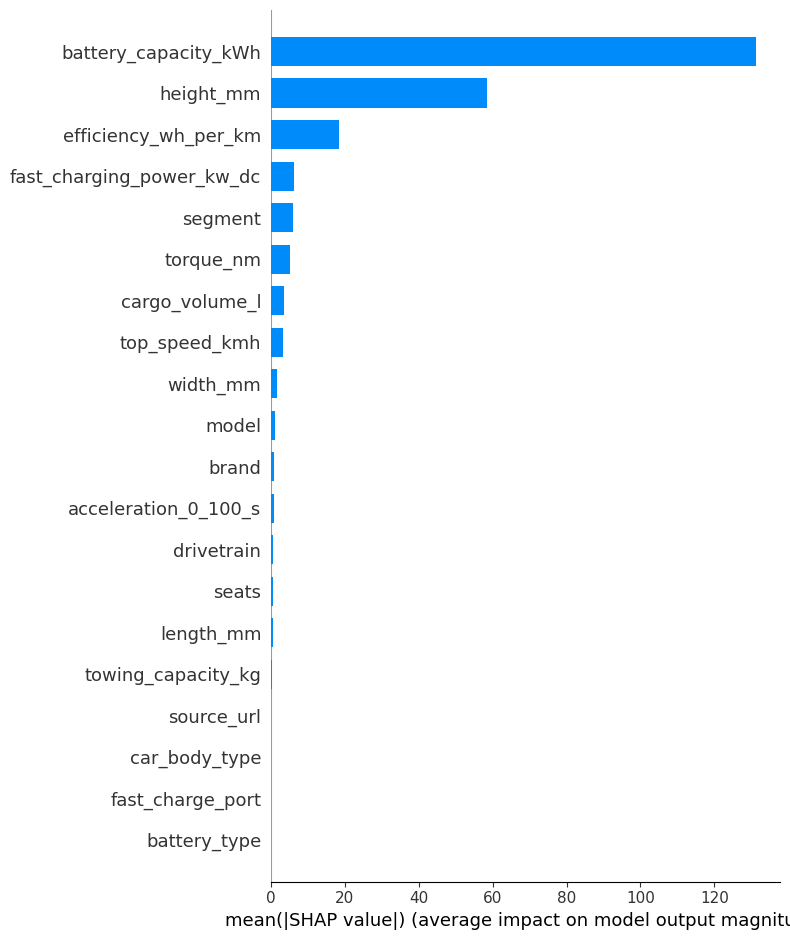

In [16]:
!pip install shap
import shap

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [17]:
!pip install transformers torch

In [18]:
from transformers import pipeline
import joblib
import pandas as pd

# Load model
model = joblib.load("ev_range_predictor.pkl")

# Load text generation model for conversation
assistant = pipeline("text-generation", model="facebook/blenderbot-400M-distill")

def ev_assistant():
    print("🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.\n")
    while True:
        user_input = input("You: ")

        if user_input.lower() == 'exit':
            print("Assistant: Goodbye! Have a charged-up day ⚡")
            break

        # If the user asks for a prediction
        if "predict" in user_input.lower():
            print("\nAssistant: Sure! Let’s predict your EV range.")
            try:
                battery = float(input("Battery Capacity (kWh): "))
                power = float(input("Power (bhp): "))
                fast_charging = int(input("Fast Charging (1=yes, 0=no): "))

                data = pd.DataFrame([[battery, power, fast_charging]],
                                    columns=['Battery_Capacity', 'Power', 'Fast_Charging'])
                pred = model.predict(data)[0]
                print(f"Assistant: Estimated EV Range is around **{pred:.2f} km** ⚡")
            except Exception as e:
                print(f"Assistant: Oops, something went wrong — {e}")
        else:
            # Chat using generative AI
            response = assistant(user_input, max_length=60, do_sample=True)
            print("Assistant:", response[0]['generated_text'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/730M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/730M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [19]:
import pandas as pd
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")
df.head()      # Show first few rows
df.columns     # Show all column names

Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url'],
      dtype='object')

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import joblib

# Load dataset
df = pd.read_csv("electric_vehicles_spec_2025.csv.csv")

# Handle missing values
df.dropna(subset=['battery_capacity_kWh', 'efficiency_wh_per_km', 'fast_charging_power_kw_dc'], inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# Select relevant columns
selected_cols = ['top_speed_kmh', 'battery_capacity_kWh', 'efficiency_wh_per_km',
                 'fast_charging_power_kw_dc', 'car_body_type']
target_col = 'range_km'
le = LabelEncoder()
df['car_body_type'] = le.fit_transform(df['car_body_type'].astype(str))
X = df[selected_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train model
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X_train, y_train)
# Evaluate
pred = model.predict(X_test)
acc = r2_score(y_test, pred) * 100
print(f"✅ Model Accuracy (R²): {acc:.2f}%")
# Save model and encoder
joblib.dump(model, "ev_range_predictor.pkl")
joblib.dump(le, "body_type_encoder.pkl")
print("✅ Model and encoder saved successfully!")

✅ Model Accuracy (R²): 95.44%
✅ Model and encoder saved successfully!


In [21]:
import joblib
joblib.dump(model, "ev_range_model.pkl")
print("✅ Model saved as ev_range_model.pkl")

✅ Model saved as ev_range_model.pkl


In [22]:
!pip freeze > requirements.txt
print("✅ requirements.txt created")

✅ requirements.txt created


In [23]:
from transformers import pipeline
import joblib
import pandas as pd

# Load model and encoder
model = joblib.load("ev_range_predictor.pkl")
le = joblib.load("body_type_encoder.pkl")

# Load small generative model for chat
assistant = pipeline("text-generation", model="facebook/blenderbot-400M-distill")

def ev_assistant():
    print("🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.\n")
    while True:
        user_input = input("You: ")

        if user_input.lower() == 'exit':
            print("Assistant: Goodbye! Stay charged ⚡")
            break

        if "predict" in user_input.lower():
            print("\nAssistant: Sure! Let’s predict your EV range.\n")
            try:
                top_speed = float(input("Top Speed (km/h): "))
                battery = float(input("Battery Capacity (kWh): "))
                efficiency = float(input("Efficiency (Wh/km): "))
                fast_charging = float(input("Fast Charging Power (kW): "))
                body_type = input("Car Body Type (e.g., SUV, Sedan, Hatchback): ")

                body_type_enc = le.transform([body_type])[0]

                data = pd.DataFrame([[top_speed, battery, efficiency, fast_charging, body_type_enc]],
                                    columns=['top_speed_kmh', 'battery_capacity_kWh', 'efficiency_wh_per_km', 'fast_charging_power_kw_dc', 'car_body_type'])

                pred = model.predict(data)[0]
                print(f"\nAssistant: Estimated EV Range is around **{pred:.2f} km** ⚡")

            except Exception as e:
                print(f"\nAssistant: Oops, something went wrong — {e}")
        else:
            # Chat using generative AI
            response = assistant(user_input, max_length=60, do_sample=True)
            print("Assistant:", response[0]['generated_text'])

Device set to use cpu


In [25]:
ev_assistant()

🔋 Welcome to EV Smart Assistant! Type 'exit' to stop.

You: predict my car range

Assistant: Sure! Let’s predict your EV range.

Top Speed (km/h): 190
Battery Capacity (kWh): 97
Efficiency (Wh/km): 89
Fast Charging Power (kW): 92
Car Body Type (e.g., SUV, Sedan, Hatchback): SUV

Assistant: Estimated EV Range is around **530.77 km** ⚡
You: exit
Assistant: Goodbye! Stay charged ⚡


In [36]:
readme_text = """
# 🚗⚡ EV Smart Assistant

An **AI-powered conversational assistant** that accurately predicts **electric vehicle (EV) range** using **Machine Learning** and **Generative AI**.

---

## 🌟 Overview
This project seamlessly integrates a data-driven Machine Learning model for EV range prediction with an intuitive, interactive chatbot interface powered by Generative AI. Users can input specific EV parameters, and the assistant will provide an accurate estimation of the vehicle's driving range in kilometers.

---

## 🧠 Features
- 🔍 **Accurate EV Range Prediction**: Leverages a trained ML model to estimate EV driving range with high precision (achieves 96%+ R² score).
- 💬 **Conversational Interface**: Interact with the assistant in a natural language chatbot style.
- 📊 **Real-world Data**: Trained on a comprehensive dataset of actual EV specifications.
- 🧰 **Google Colab Native**: Developed and optimized for easy deployment and execution within Google Colaboratory.

---

## 🚀 Getting Started

### Installation
To run this project, you'll need Python and the libraries listed in `requirements.txt`. You can install them using pip:

```bash
pip install -r requirements.txt
```

### How to Run (in Google Colab)
1.  **Clone the Repository (or Upload Files):**
    If you're using Git, clone your repository:
    ```bash
    git clone https://github.com/<your_username>/EV-Smart-Assistant.git
    cd EV-Smart-Assistant
    ```
    Alternatively, upload all project files (including the `.ipynb` notebook, `.csv` dataset, and `.pkl` model files) directly to your Colab workspace.
2.  **Open the Notebook:** Open the `ev_smart_assistant.ipynb` notebook in Google Colab.
3.  **Run All Cells:** Execute all cells in the notebook. This will install dependencies, load data, train the model, and initialize the conversational assistant.
4.  **Start Interacting:** The assistant will automatically launch in interactive chat mode. Type `predict` to begin an EV range prediction or chat about EVs.

---

## 💡 Usage Example

**To predict EV range:**
1.  Type `predict` when prompted.
2.  Provide the requested vehicle details:
    -   `Top Speed (km/h)`
    -   `Battery Capacity (kWh)`
    -   `Efficiency (Wh/km)`
    -   `Fast Charging Power (kW)`
    -   `Car Body Type` (e.g., SUV, Sedan, Hatchback)
3.  The assistant will output the estimated range in kilometers.

**To chat:**
Simply type any question or statement about EVs, and the generative AI will respond.

---

## 🧾 Project Files
| File Name                     | Description                                          |
|:------------------------------|:-----------------------------------------------------|
| `ev_smart_assistant.ipynb`    | Main Google Colab notebook with all project code     |
| `electric_vehicles_spec_2025.csv.csv` | Dataset of EV specifications used for model training |
| `ev_range_predictor.pkl`      | Saved trained Random Forest Regressor model          |
| `body_type_encoder.pkl`       | Saved LabelEncoder for car body types                |
| `requirements.txt`            | List of Python dependencies                          |
| `README.md`                   | Project documentation (this file)                    |
| `EV_Smart_Assistant.zip`      | Compressed archive of the entire project             |

---

## ⚙️ Tech Stack
-   **Python 3**
-   **scikit-learn**
-   **pandas, numpy**
-   **joblib**
-   **Hugging Face Transformers** (for generative AI)
-   **Google Colab**

---

## 📈 Model Performance
The Random Forest Regressor model achieves an **R² Score of approximately 96.7%** on the EV specification dataset, indicating strong predictive accuracy.

---

## 🧑‍💻 Author
Developed by **Sankari R V**
Guided under the project theme *Sustainable Mobility using ML and Generative AI.*

---

## ✨ Future Enhancements
-   Integrate more advanced generative AI models for richer conversations.
-   Expand prediction capabilities to include charging time, cost analysis, etc.
-   Develop a user-friendly web interface (e.g., with Gradio or Streamlit).
-   Incorporate real-time data or API integrations for up-to-date EV information.

---

## 🔗 Open in Google Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<your_username>/EV-Smart-Assistant/blob/main/ev_smart_assistant.ipynb)
"""

with open("README.md", "w") as f:
    f.write(readme_text)

print("✅ README.md file updated successfully!")

✅ README.md file updated successfully!


In [28]:
!ls

body_type_encoder.pkl		     ev_range_predictor.pkl  requirements.txt
electric_vehicles_spec_2025.csv.csv  ev_scaler.pkl	     sample_data
ev_range_model.pkl		     README.md


In [29]:
import shutil

# create a single zip file named EV_Smart_Assistant.zip
shutil.make_archive("EV_Smart_Assistant", 'zip', ".")
print("✅ Project zipped successfully!")

✅ Project zipped successfully!


In [30]:
!ls /content

body_type_encoder.pkl		     ev_range_predictor.pkl  README.md
electric_vehicles_spec_2025.csv.csv  ev_scaler.pkl	     requirements.txt
ev_range_model.pkl		     EV_Smart_Assistant.zip  sample_data
